# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-04 11:50:34.529614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 11:50:34.529691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# VAE Base Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

## Define VAE as a Model

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train VAE Model

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=5, batch_size=128)

In [ ]:
mnist_digits.shape

## Display Sample

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


## Latent Space Cluster

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


# VAE Smile Model

## Class Sampling

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [31]:
latent_dim = 32

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 32)   896         ['input_7[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 16384)        0           ['conv2d_7[0][0]']               
                                                                                            

## Decoder

In [34]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 256))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_8 (Dense)             (None, 65536)             2162688   
                                                                 
 reshape_4 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 64)       147520    
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 64, 64, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 64, 64, 3)        867 

## Define VAE as a Model

In [35]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train Smile Model

## Get Data

In [17]:
from icangetyoursmile.utils import get_dataset_tts

In [62]:
path = "../../raw_data"

X, y, X_test, y_test, X_visu, y_visu = get_dataset_tts(path, sample_size=1500)

Loading data from ../../raw_data/64x64/...
Done
X shape : (1275, 64, 64, 3)
y shape : (1275, 64, 64, 3)
X_test shape : (225, 64, 64, 3)
y_test shape : (225, 64, 64, 3)
X_visu shape : (5, 64, 64, 3)
y_visu shape : (5, 64, 64, 3)


In [90]:
X_st = y.astype("float32") / 255

In [91]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [92]:
epochs = 500
batch_size = 128

In [104]:
history = vae.fit(X_st, epochs=epochs, batch_size=batch_size)

Epoch 1/500
10/10 [==============================] - 3s 320ms/step - loss: 281.6625 - reconstruction_loss: 249.2528 - kl_loss: 29.3695
Epoch 2/500
10/10 [==============================] - 3s 327ms/step - loss: 283.1991 - reconstruction_loss: 254.8880 - kl_loss: 29.1816
Epoch 3/500
10/10 [==============================] - 3s 320ms/step - loss: 285.8359 - reconstruction_loss: 253.0401 - kl_loss: 29.1366
Epoch 4/500
10/10 [==============================] - 3s 317ms/step - loss: 276.5881 - reconstruction_loss: 249.9970 - kl_loss: 29.2881
Epoch 5/500
10/10 [==============================] - 3s 332ms/step - loss: 280.6922 - reconstruction_loss: 251.5026 - kl_loss: 29.4208
Epoch 6/500
10/10 [==============================] - 3s 318ms/step - loss: 277.4128 - reconstruction_loss: 249.0491 - kl_loss: 29.4264
Epoch 7/500
10/10 [==============================] - 3s 321ms/step - loss: 283.0547 - reconstruction_loss: 252.6768 - kl_loss: 29.2446
Epoch 8/500
10/10 [==============================] - 3s

10/10 [==============================] - 3s 310ms/step - loss: 280.2586 - reconstruction_loss: 252.9390 - kl_loss: 29.1438
Epoch 62/500
10/10 [==============================] - 3s 308ms/step - loss: 280.0772 - reconstruction_loss: 251.0424 - kl_loss: 29.1741
Epoch 63/500
10/10 [==============================] - 3s 313ms/step - loss: 280.9631 - reconstruction_loss: 249.9072 - kl_loss: 29.1217
Epoch 64/500
10/10 [==============================] - 3s 325ms/step - loss: 275.8319 - reconstruction_loss: 246.5372 - kl_loss: 29.1778
Epoch 65/500
10/10 [==============================] - 3s 309ms/step - loss: 273.5347 - reconstruction_loss: 245.1747 - kl_loss: 29.3848
Epoch 66/500
10/10 [==============================] - 3s 310ms/step - loss: 272.6408 - reconstruction_loss: 244.4784 - kl_loss: 29.5399
Epoch 67/500
10/10 [==============================] - 3s 310ms/step - loss: 275.2240 - reconstruction_loss: 246.8265 - kl_loss: 29.3507
Epoch 68/500
10/10 [==============================] - 3s 318m

10/10 [==============================] - 3s 316ms/step - loss: 278.5663 - reconstruction_loss: 248.1099 - kl_loss: 29.3612
Epoch 122/500
10/10 [==============================] - 3s 313ms/step - loss: 281.0822 - reconstruction_loss: 248.7511 - kl_loss: 29.2570
Epoch 123/500
10/10 [==============================] - 3s 323ms/step - loss: 273.0729 - reconstruction_loss: 245.9990 - kl_loss: 29.2732
Epoch 124/500
10/10 [==============================] - 3s 338ms/step - loss: 272.9862 - reconstruction_loss: 243.0139 - kl_loss: 29.4981
Epoch 125/500
10/10 [==============================] - 3s 305ms/step - loss: 270.8330 - reconstruction_loss: 242.2094 - kl_loss: 29.6281
Epoch 126/500
10/10 [==============================] - 3s 304ms/step - loss: 270.9500 - reconstruction_loss: 243.3434 - kl_loss: 29.6096
Epoch 127/500
10/10 [==============================] - 3s 333ms/step - loss: 273.4688 - reconstruction_loss: 244.0145 - kl_loss: 29.4671
Epoch 128/500
10/10 [==============================] - 

10/10 [==============================] - 3s 335ms/step - loss: 275.2147 - reconstruction_loss: 244.7555 - kl_loss: 29.7908
Epoch 181/500
10/10 [==============================] - 3s 329ms/step - loss: 273.3068 - reconstruction_loss: 242.5942 - kl_loss: 29.6474
Epoch 182/500
10/10 [==============================] - 4s 351ms/step - loss: 272.5396 - reconstruction_loss: 242.8092 - kl_loss: 29.4374
Epoch 183/500
10/10 [==============================] - 3s 351ms/step - loss: 273.8487 - reconstruction_loss: 245.9583 - kl_loss: 29.2964
Epoch 184/500
10/10 [==============================] - 3s 341ms/step - loss: 282.7226 - reconstruction_loss: 251.5227 - kl_loss: 29.1669
Epoch 185/500
10/10 [==============================] - 3s 340ms/step - loss: 277.7103 - reconstruction_loss: 246.1765 - kl_loss: 29.0435
Epoch 186/500
10/10 [==============================] - 3s 328ms/step - loss: 269.7280 - reconstruction_loss: 241.6621 - kl_loss: 29.2848
Epoch 187/500
10/10 [==============================] - 

10/10 [==============================] - 3s 320ms/step - loss: 267.3633 - reconstruction_loss: 241.0964 - kl_loss: 29.1763
Epoch 240/500
10/10 [==============================] - 3s 327ms/step - loss: 271.2560 - reconstruction_loss: 242.4337 - kl_loss: 29.4576
Epoch 241/500
10/10 [==============================] - 3s 305ms/step - loss: 272.7252 - reconstruction_loss: 242.1149 - kl_loss: 29.4795
Epoch 242/500
10/10 [==============================] - 3s 308ms/step - loss: 267.1171 - reconstruction_loss: 238.5260 - kl_loss: 29.4187
Epoch 243/500
10/10 [==============================] - 3s 308ms/step - loss: 268.5652 - reconstruction_loss: 239.2299 - kl_loss: 29.5521
Epoch 244/500
10/10 [==============================] - 3s 315ms/step - loss: 266.5300 - reconstruction_loss: 239.5764 - kl_loss: 29.6395
Epoch 245/500
10/10 [==============================] - 3s 314ms/step - loss: 267.1196 - reconstruction_loss: 238.1200 - kl_loss: 29.5059
Epoch 246/500
10/10 [==============================] - 

10/10 [==============================] - 3s 329ms/step - loss: 265.2419 - reconstruction_loss: 236.1810 - kl_loss: 29.7746
Epoch 299/500
10/10 [==============================] - 3s 339ms/step - loss: 267.2189 - reconstruction_loss: 236.6862 - kl_loss: 29.7285
Epoch 300/500
10/10 [==============================] - 3s 322ms/step - loss: 264.7406 - reconstruction_loss: 236.3501 - kl_loss: 29.5360
Epoch 301/500
10/10 [==============================] - 3s 317ms/step - loss: 266.3663 - reconstruction_loss: 239.9853 - kl_loss: 29.5380
Epoch 302/500
10/10 [==============================] - 3s 316ms/step - loss: 270.9584 - reconstruction_loss: 240.7078 - kl_loss: 29.4269
Epoch 303/500
10/10 [==============================] - 3s 315ms/step - loss: 269.2560 - reconstruction_loss: 239.9634 - kl_loss: 29.3554
Epoch 304/500
10/10 [==============================] - 3s 318ms/step - loss: 268.3360 - reconstruction_loss: 241.2307 - kl_loss: 29.3088
Epoch 305/500
10/10 [==============================] - 

10/10 [==============================] - 6s 559ms/step - loss: 268.2833 - reconstruction_loss: 241.1574 - kl_loss: 29.5592
Epoch 358/500
10/10 [==============================] - 6s 568ms/step - loss: 272.3697 - reconstruction_loss: 241.7590 - kl_loss: 29.2167
Epoch 359/500
10/10 [==============================] - 6s 564ms/step - loss: 266.4806 - reconstruction_loss: 237.9406 - kl_loss: 29.1424
Epoch 360/500
10/10 [==============================] - 6s 564ms/step - loss: 264.9313 - reconstruction_loss: 236.4507 - kl_loss: 29.5907
Epoch 361/500
10/10 [==============================] - 5s 547ms/step - loss: 267.3649 - reconstruction_loss: 236.0488 - kl_loss: 29.8729
Epoch 362/500
10/10 [==============================] - 5s 544ms/step - loss: 266.6062 - reconstruction_loss: 237.1210 - kl_loss: 29.8190
Epoch 363/500
10/10 [==============================] - 6s 555ms/step - loss: 265.7805 - reconstruction_loss: 237.2303 - kl_loss: 29.5309
Epoch 364/500
10/10 [==============================] - 

10/10 [==============================] - 6s 573ms/step - loss: 267.1966 - reconstruction_loss: 237.0457 - kl_loss: 29.7419
Epoch 417/500
10/10 [==============================] - 5s 545ms/step - loss: 267.2030 - reconstruction_loss: 236.7511 - kl_loss: 29.5265
Epoch 418/500
10/10 [==============================] - 6s 565ms/step - loss: 263.8218 - reconstruction_loss: 234.3416 - kl_loss: 29.6944
Epoch 419/500
10/10 [==============================] - 6s 580ms/step - loss: 268.7334 - reconstruction_loss: 239.4702 - kl_loss: 29.5488
Epoch 420/500
10/10 [==============================] - 6s 570ms/step - loss: 263.3485 - reconstruction_loss: 235.2411 - kl_loss: 29.3596
Epoch 421/500
10/10 [==============================] - 6s 565ms/step - loss: 267.7876 - reconstruction_loss: 241.5762 - kl_loss: 29.5023
Epoch 422/500
10/10 [==============================] - 6s 595ms/step - loss: 267.2436 - reconstruction_loss: 239.3529 - kl_loss: 29.3799
Epoch 423/500
10/10 [==============================] - 

10/10 [==============================] - 6s 571ms/step - loss: 264.5535 - reconstruction_loss: 237.2688 - kl_loss: 29.5372
Epoch 476/500
10/10 [==============================] - 6s 586ms/step - loss: 264.0289 - reconstruction_loss: 236.5565 - kl_loss: 29.6176
Epoch 477/500
10/10 [==============================] - 6s 585ms/step - loss: 268.3546 - reconstruction_loss: 240.2968 - kl_loss: 29.6503
Epoch 478/500
10/10 [==============================] - 6s 582ms/step - loss: 271.8894 - reconstruction_loss: 244.0407 - kl_loss: 29.5387
Epoch 479/500
10/10 [==============================] - 5s 549ms/step - loss: 271.5900 - reconstruction_loss: 242.4434 - kl_loss: 29.2684
Epoch 480/500
10/10 [==============================] - 6s 557ms/step - loss: 264.0300 - reconstruction_loss: 236.7517 - kl_loss: 29.3176
Epoch 481/500
10/10 [==============================] - 6s 597ms/step - loss: 265.9107 - reconstruction_loss: 238.1118 - kl_loss: 29.6699
Epoch 482/500
10/10 [==============================] - 

In [105]:
loss = history.history["loss"]
r_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]
epoch_range = range(epochs)
epoch_range

range(0, 500)

## Plot losses

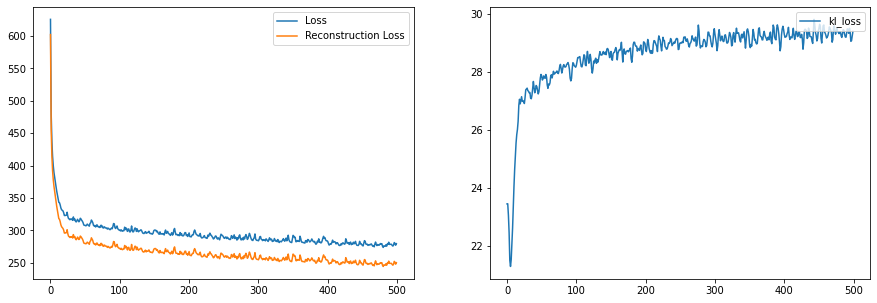

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

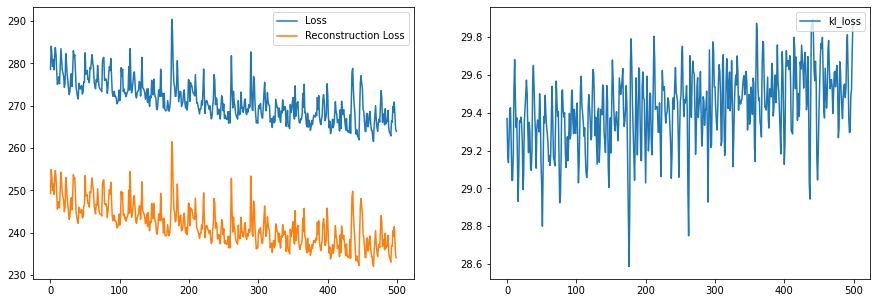

In [106]:
plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

In [107]:
res = vae.encoder.predict(X_st)

In [108]:
res

[array([[-6.0688751e-03,  3.1957038e-02, -3.5477096e-01, ...,
          2.4153082e-02, -4.3564960e-02,  2.0445433e-02],
        [-2.3504335e-03, -1.0466687e-02,  4.3975890e-02, ...,
          1.3224281e-02, -5.7964083e-03,  1.8387575e-02],
        [-5.0732261e-04, -2.6822452e-02,  5.8842838e-01, ...,
          1.0927718e-02,  1.7524492e-03,  1.7365990e-02],
        ...,
        [-6.8694558e-03,  3.1077839e-02,  2.0928397e+00, ...,
          2.3460491e-02, -4.2105600e-02,  1.9869886e-02],
        [-5.8551636e-03,  4.1532449e-02,  1.5873477e+00, ...,
          2.7812293e-02, -4.6761423e-02,  1.9524634e-02],
        [-5.1223403e-03,  2.6846968e-02, -7.6999396e-02, ...,
          2.3518223e-02, -3.8601123e-02,  1.9861285e-02]], dtype=float32),
 array([[-0.6951418 , -0.5027963 , -6.5484576 , ..., -0.6971983 ,
         -0.71792674, -0.59143245],
        [-0.8277868 , -0.7337777 , -6.4418855 , ..., -0.81676406,
         -0.83728224, -0.77819407],
        [-0.88933885, -0.82109576, -6.49287   

In [99]:
import matplotlib.image as mpimg

In [109]:
res_f = vae.decoder.predict(res[0])

In [110]:
res_f[0][0]

array([[0.17826378, 0.14199391, 0.10204792],
       [0.17682987, 0.1387293 , 0.09422696],
       [0.19550982, 0.1576913 , 0.1068916 ],
       [0.18549052, 0.14627105, 0.09775448],
       [0.19840685, 0.16239357, 0.10944873],
       [0.20363438, 0.15837276, 0.10605097],
       [0.21356905, 0.16111043, 0.10735348],
       [0.2297413 , 0.16974941, 0.1115222 ],
       [0.2901401 , 0.2177209 , 0.149867  ],
       [0.28271717, 0.21487647, 0.15159625],
       [0.25524074, 0.20934245, 0.14822027],
       [0.22471878, 0.18145359, 0.12329978],
       [0.2018964 , 0.16557178, 0.11187518],
       [0.19104022, 0.15489528, 0.10525012],
       [0.20576525, 0.16417864, 0.11077401],
       [0.22322845, 0.16660109, 0.11051583],
       [0.24797949, 0.18234935, 0.12257785],
       [0.23949397, 0.178763  , 0.12125531],
       [0.25419408, 0.19384333, 0.13200694],
       [0.2575919 , 0.19353041, 0.13450977],
       [0.2816288 , 0.21757329, 0.15744698],
       [0.22993538, 0.17911118, 0.13081375],
       [0.

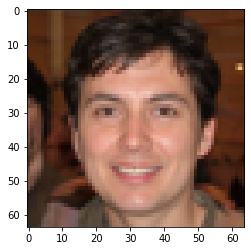

In [103]:
plt.imshow(y[0])

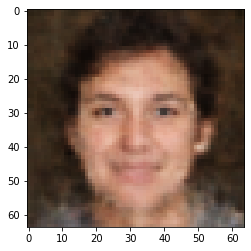

In [111]:
plt.imshow(res_f[0])